In [1]:
# https://machinelearningmastery.com/lstm-autoencoders/
# https://github.com/gentnerlab/buckeye/blob/master/buckeye_seq2seq.py

In [2]:
from IPython import display

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
import tensorflow as tf
import numpy as np

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [4]:
def visualize_results(model, dataset):
    x_batch = next(iter(dataset))
    z = model.encode(x_batch)
    x_recon = model.decode(z)
    nex = 10
    fig, axs = plt.subplots(nrows = 2, ncols=nex, figsize=(nex*2, 4))
    for i in range(nex):
        axs[0,i].matshow(x_recon.numpy()[i].squeeze(), vmin=0, vmax = 1, cmap = plt.cm.Greys)
        axs[1,i].matshow(x_batch.numpy()[i].squeeze(), vmin=0, vmax = 1, cmap = plt.cm.Greys)
        axs[0,i].axis('off')
        axs[1,i].axis('off')
    plt.show()

In [5]:
from avgn.networks.test_datasets import load_fashion_MNIST
# get the datasets
ds, test_dataset = load_fashion_MNIST(TRAIN_BUF=60000, BATCH_SIZE=1024)

In [6]:
seq_len = 7
ndims = 28

In [7]:
ds

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [8]:
from tensorflow.keras.layers import (
    RepeatVector,
    Dense,
    TimeDistributed,
    Conv1D,
    Conv2D,
    Reshape,
)  # , LSTM
from tensorflow.python.keras.layers.recurrent import UnifiedLSTM as LSTM


In [9]:
class seq2seq_autoencoder(tf.keras.Model):
    """ an autoencoder based on LSTM 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(seq2seq_autoencoder, self).__init__()
        self.__dict__.update(kwargs)
        self.enc = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(
                    filters=32,
                    kernel_size=3,
                    strides=(2, 2),
                    activation="relu",
                    padding="same",
                ),
                tf.keras.layers.Conv2D(
                    filters=64,
                    kernel_size=3,
                    strides=(2, 2),
                    activation="relu",
                    padding="same",
                ),
                Reshape(target_shape=(7, 7 * 64)),
                LSTM(units=100, activation="relu"),
                Dense(units=100),
            ]
        )

        self.dec = tf.keras.Sequential(
            [
                Dense(units=100),
                RepeatVector(seq_len),
                LSTM(units=100, activation="relu", return_sequences=True),
                TimeDistributed(Dense(7 * 64)),
                Reshape(target_shape=(7, 7, 64)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation="sigmoid",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation="sigmoid",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=1,
                    kernel_size=3,
                    strides=(1, 1),
                    padding="SAME",
                    activation="sigmoid",
                ),
                Reshape(target_shape=(28, 28, 1)),
            ]
        )

    @tf.function   
    def encode(self, x):
        return self.enc(x)
    @tf.function
    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        z = self.encode(x)
        _x = self.decode(z)
        ae_loss = tf.reduce_mean(tf.square(x - _x))
        return ae_loss

    @tf.function
    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as tape:
            ae_loss = self.compute_loss(x)

        # compute gradients
        gradients = tape.gradient(ae_loss, self.trainable_variables)

        return gradients

    @tf.function
    def apply_gradients(self, gradients):
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    def train(self, train_dataset):
        for train_x in tqdm(train_dataset, leave=False):
            gradients = self.compute_gradients(train_x)
            self.apply_gradients(gradients)

In [11]:
optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

model = seq2seq_autoencoder(
    #enc = enc,
    #dec = dec,
    optimizer = optimizer
)

W0505 13:32:57.602119 140327578892032 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa008582358>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0505 13:32:57.614114 140327578892032 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa008526be0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [12]:
model.enc(next(iter(ds))).shape

TensorShape([512, 100])

In [13]:
model.dec(model.enc(next(iter(ds)))).shape

TensorShape([512, 28, 28, 1])

In [14]:
losses = []

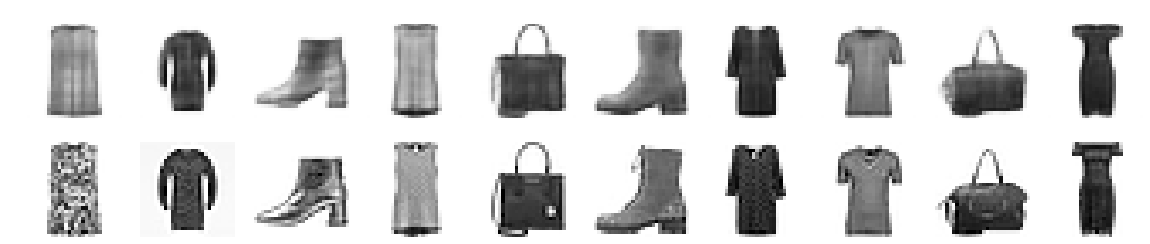

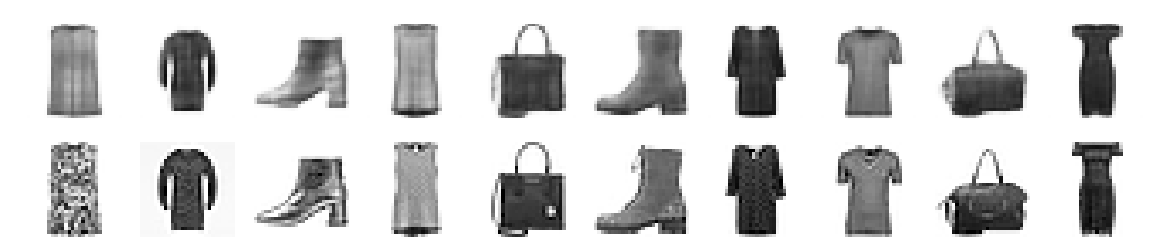

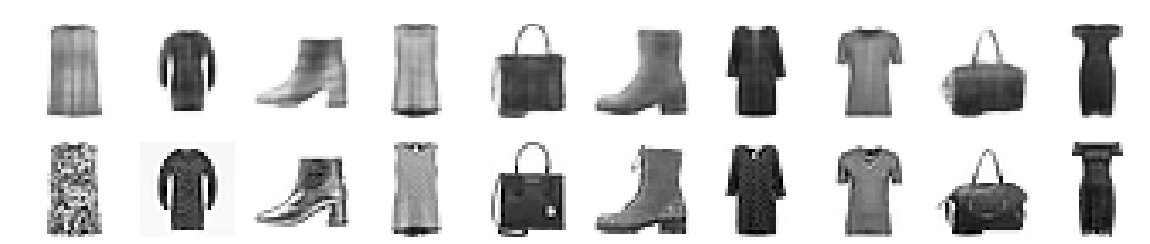

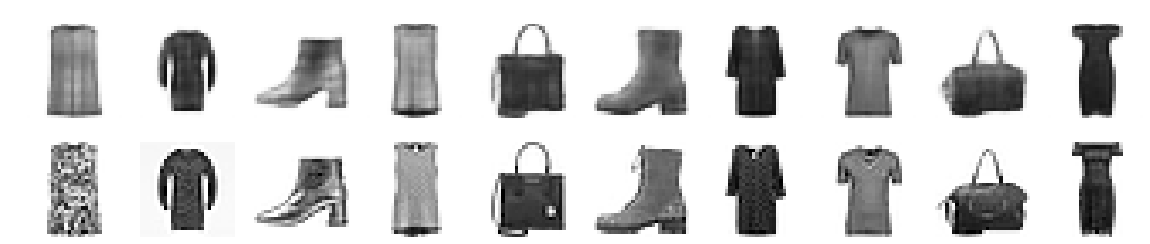

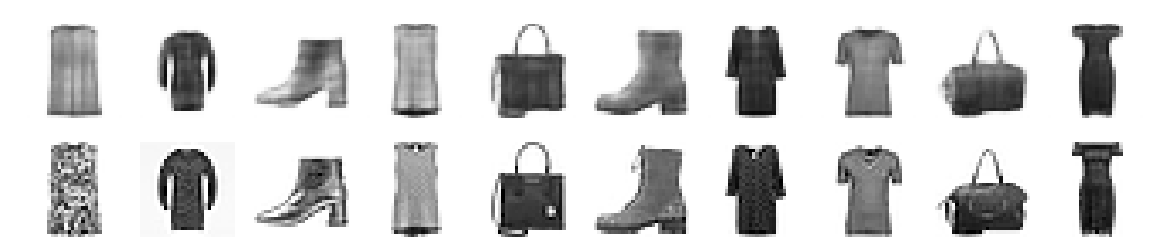

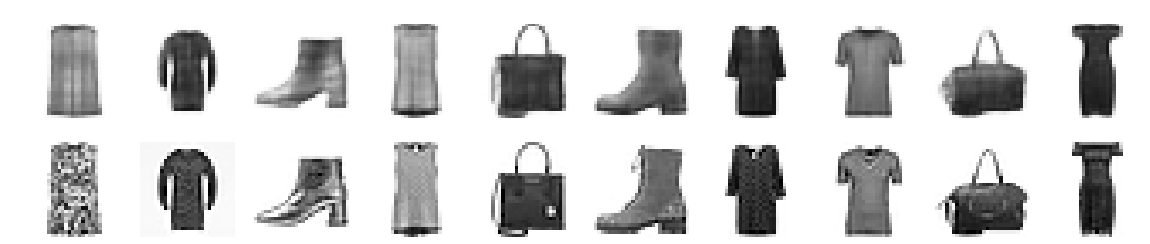

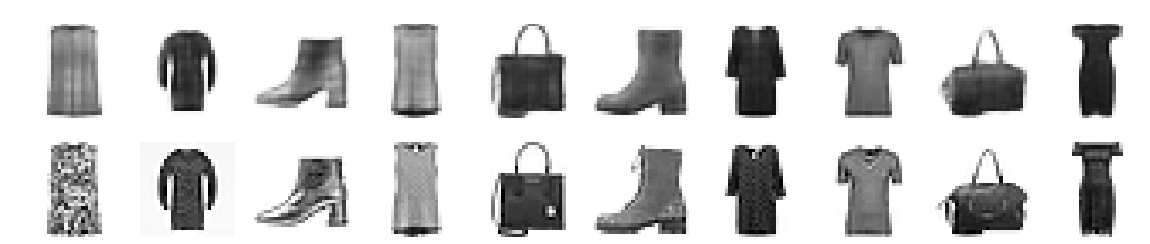

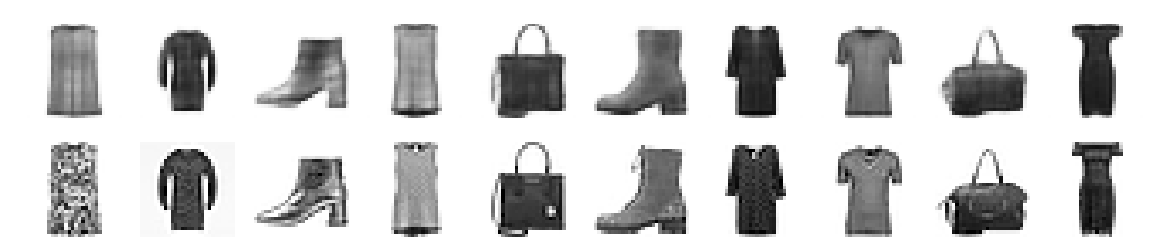

In [ ]:
for epoch in range(1000):
    model.train(train_dataset=ds)
    # compute loss
    batch_loss = np.sum(model.compute_loss(next(iter(ds))).numpy())
    losses.append(batch_loss)
    if epoch % 10 == 0:
        display.clear_output(wait=False)
    # viz results
    visualize_results(model, ds)

In [ ]:
plt.plot(losses)

In [ ]:
visualize_results(model, ds)

In [ ]:
plt.plot(losses)